In [966]:
import numpy as np
import matplotlib.pyplot as plt

# Данные для теста алгоритма:

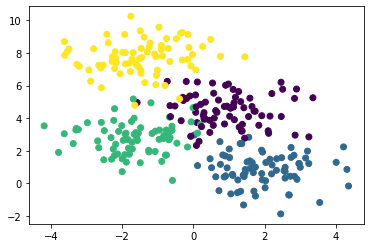

In [1036]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 300,  centers = 4, random_state = 0)

plt.scatter(X[:, 0], X[:, 1], c = y)

# Реализация алгоритма KMeans:

In [1076]:
class KMeans:
    def RandomInitilization(self, X, k):
        self.Centers = X[np.random.choice(len(X), k)]

    def KmeansPlusPlusInitilization(self, X, k):
        self.Centers = [X[np.random.randint(0, len(X) - 1)]]

        for i in range(1, k):
            dist = np.array([np.linalg.norm(self.Centers - CurElem, axis=1).min() for CurElem in X])
            self.Centers.append(X[np.argmax(dist, axis = 0)])

    def AssignClusters(self, X):
        return np.array([np.argmin(np.linalg.norm(self.Centers - CurElem, axis = 1)) for CurElem in X])
                
    def MoveCenters(self, X, k, NewClusters):
        CurCenters = np.zeros_like(self.Centers)

        for i in range(k):
            CurCluster = X[NewClusters == i]
            CurCenters[i] = np.mean(CurCluster, axis = 0)

        return CurCenters

    def ElbowDist(self, X, k):
        # find mean sum of squared distance between clusters elements
        Sum = 0

        for i in range (k):
            CurCluster = X[self.Clusters == i]
            for CurElem in CurCluster:
                Sum += np.sum(np.linalg.norm(self.Centers[i] - CurElem, axis=0)**2)

        return Sum / k

    def TransformData(self, X, k, InitilizationType = 'random', NumberIterations = False, Find = False):
        # main fuction
        self.count = 0

        if InitilizationType == 'random':
            self.RandomInitilization(X, k)
        elif InitilizationType == 'kmeans_pp':
            self.KmeansPlusPlusInitilization(X, k)
        else:
            print('Initialization error')
        
        flag = False
        while not flag:
            NewClusters = self.AssignClusters(X)
            NewCenters = self.MoveCenters(X, k, NewClusters)
            self.count += 1
            if np.linalg.norm(NewCenters - self.Centers) >= 1e-6:
                self.Centers = NewCenters
                if self.count > 300:
                    print('Algorithm stuck')
                    break
            else:
                flag = True
                self.Clusters = NewClusters
                if Find:
                    self.AvSum = self.ElbowDist(X, k)
                if NumberIterations:
                    print(f'Num of iteration for which algorithm converged: {self.count}')

        return self

## Определим правильное количество кластеров с помощью метода локтя:

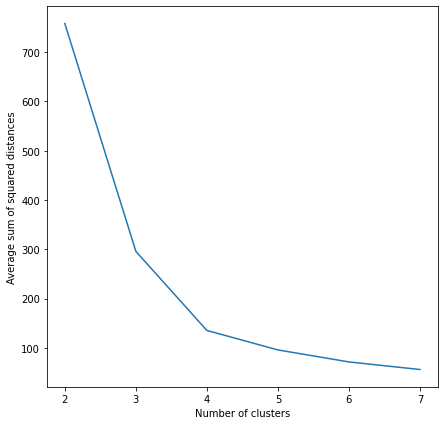

In [1037]:
km = KMeans()
AverageClusterDistances = []
InitilizationType = 'random'
NumberIterations = False

for k in range(2, 8):
    km.TransformData(X, k, Find = True)
    AverageClusterDistances.append(km.AvSum)

plt.figure(figsize=(7, 7))
plt.xlabel('Number of clusters')
plt.ylabel('Average sum of squared distances')
plt.plot(range(2, 8), AverageClusterDistances)

После точки k = 4, график становится плавным, а до нее - шел резко. Значит правильное число кластеров = 4

# Рассмотрим методы начальной инициализации
Случайная инициализация:

Число итераций, за которое алгоритм сошелся: 17


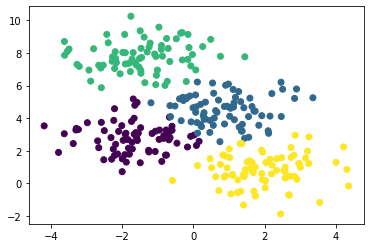

In [1038]:

InitilizationType = 'random'
km.TransformData(X, 4, InitilizationType, NumberIterations = True)
plt.scatter(X[:, 0], X[:, 1], c = km.Clusters)


Инициализация KMeans++:

Число итераций, за которое алгоритм сошелся: 6


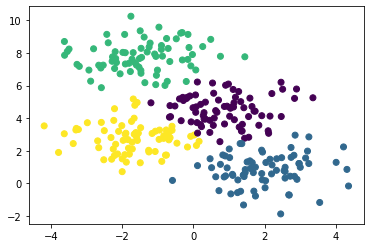

In [1039]:
km.TransformData(X, 4, InitilizationType='kmeans_pp', NumberIterations = True)
plt.scatter(X[:, 0], X[:, 1], c = km.Clusters)

Распределние по классам получилось одинаковым( за исключением пары точек )
## Исследуем на 300 различных данных, при какой инициализации алгоритм сходится быстрее:

In [1040]:
%%time
IterSum1 = 0
for i in range(300):
    X, y = make_blobs(n_samples = 300, centers = 4, random_state = i)
    km.TransformData(X, 4)
    IterSum1 += km.count


CPU times: user 11 s, sys: 15.6 ms, total: 11 s
Wall time: 11 s


In [1041]:
%%time
IterSum2 = 0
for i in range(300):
    X, y = make_blobs(n_samples = 300, centers = 4, random_state = i)
    km.TransformData(X, 4, InitilizationType = 'kmeans_pp')
    IterSum2 += km.count

CPU times: user 14 s, sys: 27.3 ms, total: 14 s
Wall time: 14.1 s


In [1042]:
print(f'Среденее число итераций при случайной ининиализации: {IterSum1 / 300}')
print(f'Среденее число итераций при ининиализации kmeans++: {IterSum2 / 300}')

Среденее число итераций при случайной ининиализации: 6.773333333333333
Среденее число итераций при ининиализации kmeans++: 4.64


При инициализации kmeans++ алгоритм сходится значительно быстрее
# Рассмотрим с какими данными алгортим работает, как надо, а для каких - нет
Введем данные с кластерами продолговатой формы:

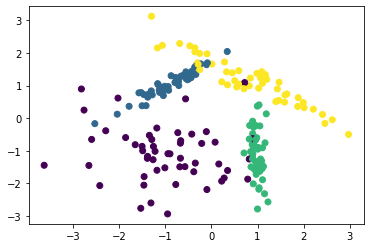

In [1064]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples = 200, n_features = 2, n_redundant=0, n_classes=4, n_clusters_per_class = 1, random_state=12)

plt.scatter(X[:, 0], X[:, 1], c = y)

Число итераций, за которое алгоритм сошелся: 7


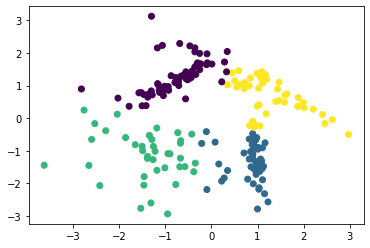

In [1066]:
km.TransformData(X, 4, InitilizationType='kmeans_pp', NumberIterations = True)
plt.scatter(X[:, 0], X[:, 1], c = km.Clusters)

Видно что алгоритм сработал неправильно

Введем данные с кластерами в форме окружности:

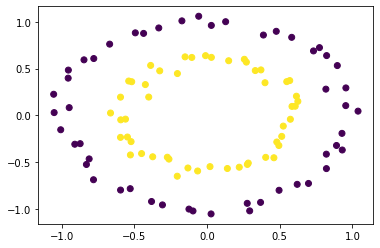

In [1067]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples = 100, factor = 0.6, noise = 0.05)

plt.scatter(X[:, 0], X[:, 1], c = y)

Число итераций, за которое алгоритм сошелся: 2


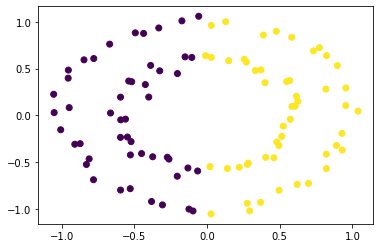

In [1068]:
km.TransformData(X, 2, InitilizationType='kmeans_pp', NumberIterations = True)
plt.scatter(X[:, 0], X[:, 1], c = km.Clusters)

Алгоритм также работает неправильно

K-means будет работать как надо, если точки в исходных кластерах лежат примерно в пределах круга. Но не так, как на пример выше
# Построим матрицу попарных расстояний:

In [999]:
# Составляет матрицу попарных расстояний по введеным данным
def CreatePairDistancesMatrix(X, Number):
    PairDistances = np.zeros((Number, Number))
    for i in range(Number):
        PairDistances[i] = np.linalg.norm(X - X[i], axis = -1)
    return PairDistances

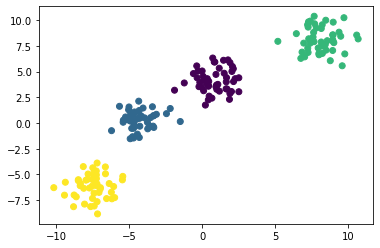

In [1070]:
NumberOfElems = 200
X, y = make_blobs(n_samples = NumberOfElems, centers = 4, random_state = 3)
plt.scatter(X[:, 0], X[:, 1], c = y)

таблица попарных расстояний для произвольного набора данных:

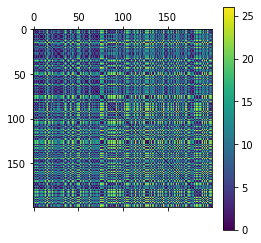

In [1071]:
Matrix = CreatePairDistancesMatrix(X, NumberOfElems)
plt.matshow(Matrix, fignum = 1)
plt.colorbar()

In [1072]:
# Сортировка массива по кластерам
km.TransformData(X, 4)
Z = np.column_stack((X, km.Clusters))
Z = sorted(Z, key = lambda Z: Z[2])

Таблица попарных расстояний для сортированных по кластерам данных

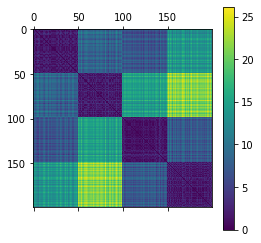

In [1073]:
Matrix = CreatePairDistancesMatrix(Z, NumberOfElems)
plt.matshow(Matrix)
plt.colorbar()

# Построим графики зависимость времени поиска кластеров и числа итераций от обьема данных/сложности задачи:

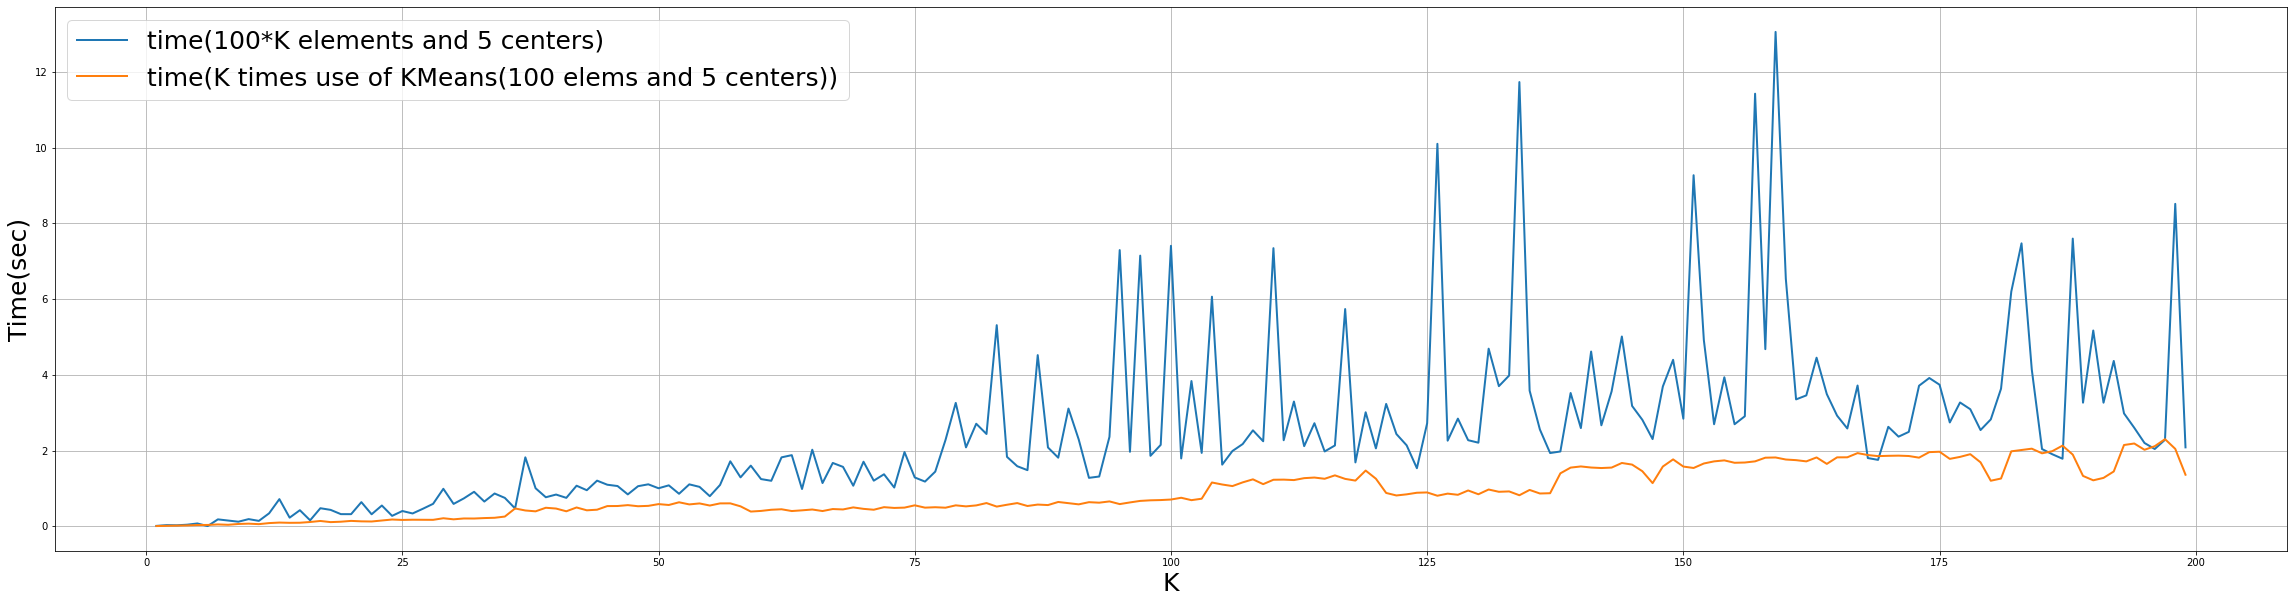

In [1082]:
import time
Itcount1 = []
TimeToDo1 = []
for k in range(1, 200):
    X, y = make_blobs(n_samples = 100*k,  centers = 5, random_state = 0)
    t1 = time.perf_counter()
    km.TransformData(X, 5)
    t2 = time.perf_counter()
    Itcount1.append(km.count)
    TimeToDo1.append(t2-t1)

TimeToDo2 = []
for k in range(1, 200):
    sumt = 0
    for j in range(k):
        X, y = make_blobs(n_samples = 100,  centers = 5, random_state = 0)
        t1 = time.perf_counter()
        km.TransformData(X, 5)
        t2 = time.perf_counter()
        sumt += (t2-t1)
    TimeToDo2.append(sumt)

plt.figure(figsize=(40, 10))
plt.xlabel('K', fontsize = 25)
plt.ylabel('Time(sec)', fontsize = 25)
plt.plot(range(1, 200) ,TimeToDo1, lw = 2, label = 'time(100*K elements and 5 centers)')
plt.plot(range(1, 200) ,TimeToDo2, lw = 2, label = 'time(K times use of KMeans(100 elems and 5 centers))')
plt.grid()
plt.legend(fontsize = 25)


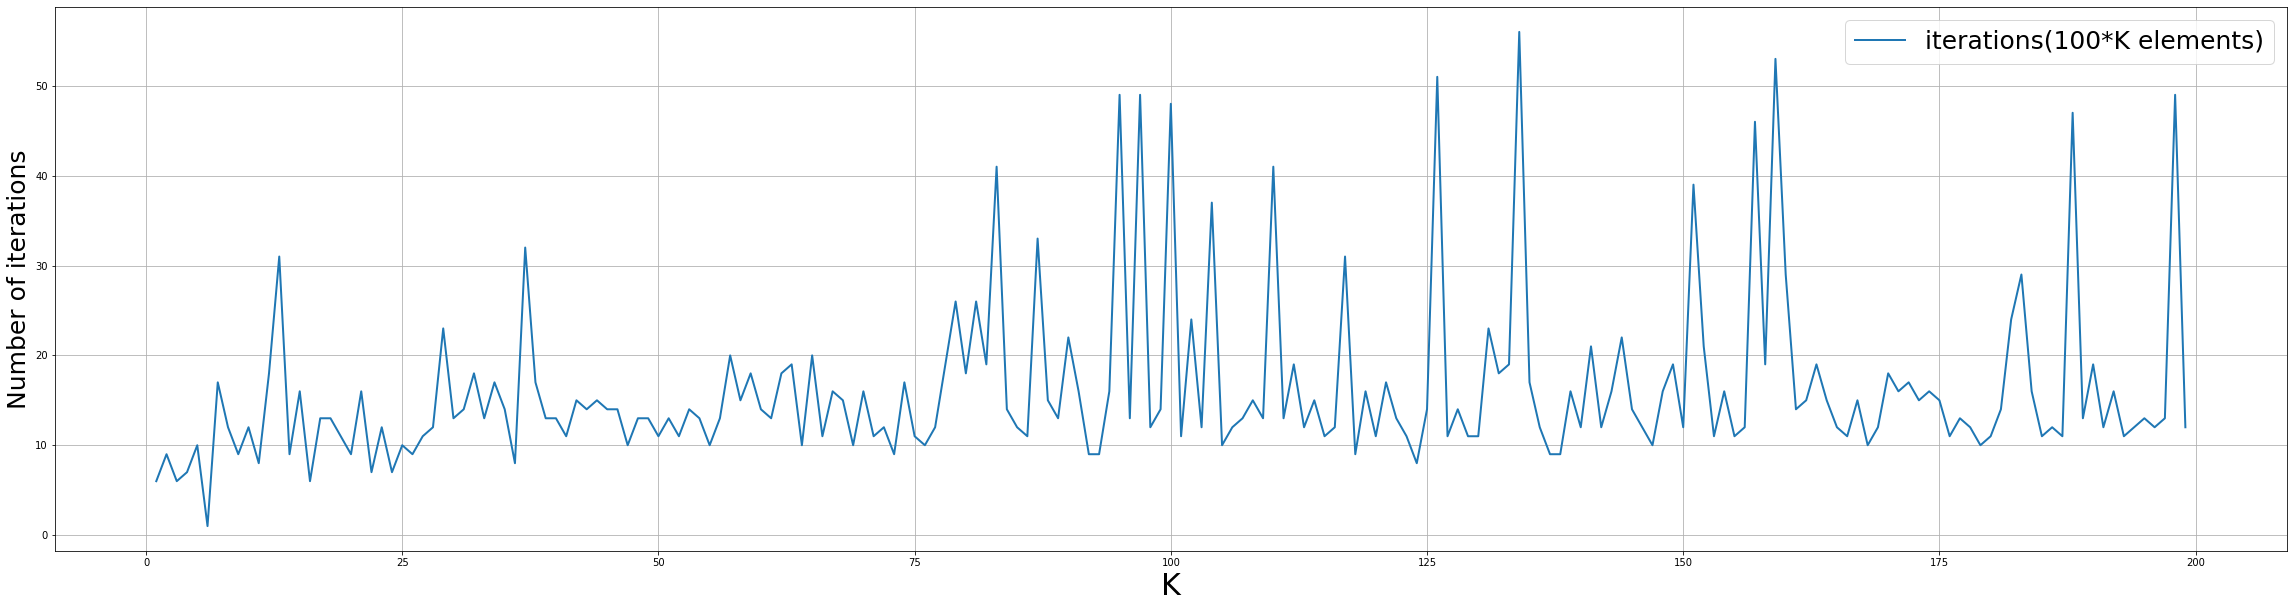

In [1083]:
plt.figure(figsize=(40, 10))
plt.xlabel('K', fontsize = 30)
plt.ylabel('Number of iterations', fontsize = 25)
plt.plot(range(1, 200) ,Itcount1, lw = 2, label = 'iterations(100*K elements)')
plt.grid()
plt.legend(fontsize = 25)

Зависимость времени от числа точек и от числа вызванных функций - линейна

График растет с примерно одинаковой скоростью при увеличении числа точек данных на 100 и при увелечении количества обращений к функции( для 100 точек) на 1 раз.  
(Количество центров фиксировано)
